### Revision:
* added 'n jaren geleden' (more common in pre-WWII era) to the phrase 'n jaar geleden' (more commen post-WWII)
* added different phrasings for 'one year ago' (like 'previous year', 'last year', etc.): 'afgeloopen jaar', 'afgelopen jaar', 'vorig jaar', 'vorige jaar', 'verleden jaar'

# Looking forward and looking back in Dutch newspapers

Code is designed for raw csv's from Delpher with 28 columns.

In [1]:
import pandas as pd
import glob
import random
import os
import string
import re
import numpy as np
from collections import Counter
from datetime import datetime
from nltk import word_tokenize
from nltk.util import ngrams
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cm as mplcm
import matplotlib.colors as colors
from matplotlib.pyplot import cm
import seaborn as sns
from tqdm.notebook import tqdm as log_progress

In [2]:
paper = 'Limburgsch Dagblad'
paper_short = 'limburgschdagblad'
path = "/Users/huijn001/surfdrive/data_lokaal/Limburgsch_Dagblad/"
allfiles = glob.glob(os.path.join(path, "*.csv"))

In [3]:
def query_column(i):
    """Function for naming df columns"""
    i_df = i.replace(' ','_')
    return i_df

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in word_tokenize(words):
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '' and len(new_word) >=3:
            new_words.append(new_word)
    words_str = (" ".join(new_words))
    return words_str

def word_count(string):
    """Function to count words in text string"""
    words = string.split()
    return len(words)

def jaar_geleden(jaar):
    jaar_geleden = jaar + ' jaar geleden'
    return str(jaar_geleden)

def jaren_geleden(jaar):
    jaren_geleden = jaar + ' jaren geleden'
    return str(jaren_geleden)

## Step 1: getting the data
Make dataframe 'corpus' from newspaper documents' date, title and text

In [4]:
sample_size = 10000
corpus = pd.DataFrame()

for filename in log_progress(allfiles):
    print(filename[-8:-4])
    n = sum(1 for line in open(filename)) #number of records in file (excludes header)
    skip = sorted(random.sample(range(1,n+1),n-sample_size)) #the 0-indexed header will not be included in the skip list
    df = pd.read_csv(filename, sep="\t", usecols=[4, 25, 28], skiprows=skip) # for Telegraaf, Limburgsch Dagblad, Leeuwarder Courant
    print("Removing " + str(len(df[df.duplicated(keep='first') == True])) + " rows...", end="\n")
    df.drop(df.index[df.duplicated(keep='first') == True], axis=0, inplace=True)
    df['text_content'] = df['text_content'].apply(str) # for Telegraaf, Limburgsch Dagblad, Leeuwarder Courant
    df['text_clean'] = df['text_content'].apply(remove_punctuation)
    df['text_clean'] = df['text_clean'].str.lower()
    corpus = pd.concat([corpus, df], axis=0, ignore_index=True)

  0%|          | 0/49 [00:00<?, ?it/s]

1974
Removing 0 rows...
1975
Removing 0 rows...
1949
Removing 1 rows...
1977
Removing 1 rows...
1963
Removing 0 rows...
1988
Removing 0 rows...
1989
Removing 0 rows...
1962
Removing 2 rows...
1976
Removing 3 rows...
1972
Removing 0 rows...
1966
Removing 1 rows...
1967
Removing 0 rows...
1973
Removing 0 rows...
1965
Removing 0 rows...
1971
Removing 0 rows...
1970
Removing 0 rows...
1964
Removing 0 rows...
1925
Removing 0 rows...
1940
Removing 0 rows...
1938
Removing 0 rows...
1953
Removing 0 rows...
1936
Removing 1 rows...
1937
Removing 0 rows...
1935
Removing 0 rows...
1927
Removing 0 rows...
1945
Removing 3 rows...
1934
Removing 0 rows...
1930
Removing 0 rows...
1922
Removing 1 rows...
1931
Removing 0 rows...
1929
Removing 0 rows...
1933
Removing 0 rows...
1932
Removing 0 rows...
1969
Removing 0 rows...
1955
Removing 28 rows...
1982
Removing 0 rows...
1983
Removing 1 rows...
1954
Removing 26 rows...
1968
Removing 0 rows...
1956
Removing 19 rows...
1981
Removing 0 rows...
1951
Removing

In [5]:
print(corpus.head())

  paper_dc_date                          article_dc_title  \
0    1974-02-19  VVD-Limburg lanceert haar actieprogramma   
1    1974-06-22                                HOENSBROEK   
2    1974-06-29                     van de hoofdredacteur   
3    1974-02-15                                  Susteren   
4    1974-02-08                                  B.R.T. n   

                                        text_content  \
0  ROERMOND — In de stellige verwachting op provi...   
1  KASTEEL schilderijenexpositie „objectief gezie...   
2  krant is verrijkt met een bijlage over het Wer...   
3  — Zaterdag houdt de harmonie St. Cecilia een k...   
4  198 m; FM-kanalen 22 en 36  Nieuws: 5.30, 6, 6...   

                                          text_clean  
0  roermond stellige verwachting provinciaal nive...  
1  kasteel schilderijenexpositie objectief gezien...  
2  krant verrijkt met een bijlage over het wereld...  
3  zaterdag houdt harmonie cecilia een kienavond ...  
4  198 fmkanalen nieu

Turn date column into datetime index, remove old date and raw text columns 

In [6]:
corpus['date'] = pd.to_datetime(corpus['paper_dc_date'], format ="%Y-%m-%d")
corpus = corpus.set_index('date') # voor het tellen van jaren waarnaar indirect verwezen wordt is date als index niet handig
corpus = corpus.drop(columns=['paper_dc_date', 'text_content'])
corpus.sort_index(inplace=True)

In [7]:
corpus["no_words"] = corpus["text_clean"].str.len()

In [8]:
print(corpus.head())

                                             article_dc_title  \
date                                                            
1918-10-05                            Arbeidsaangelegenheden.   
1918-10-05  LIMBURGSCH DAGBLAD Zaterdag 50 steber-Tweede B...   
1918-10-05                                    Vliegerongeval.   
1918-10-05  INGEZONDEN. Een outorekende Orgaa. Geachte Red...   
1918-10-05                     Spaarfonds voor Boderacultuur.   

                                                   text_clean  no_words  
date                                                                     
1918-10-05  jaarvergadering van den ned naaisters kleermak...       880  
1918-10-05                                                            0  
1918-10-05  giserermorgen luitenant coblijn soesterberg me...       554  
1918-10-05  moge elk dezer regelen zijn een heele slag aan...      1705  
1918-10-05  stichting spaarfonds voor bodemcultuur zeiel h...       828  


### If needed: Count number of trigrams per year

In [ ]:
corpus['tokenized'] = corpus.apply(lambda row: 
    word_tokenize(str(row['text_clean'])), axis=1)

In [ ]:
n = 3  # Change 'n' to any other number to generate n-grams of different lengths

# Define a function to count trigrams
def count_trigrams(row):
    trigrams = list(ngrams(row, n))
    trigram_tuples = [tuple(trigram) for trigram in trigrams]
    trigram_counts = Counter(trigram_tuples)
    return sum(count for trigram, count in trigram_counts.items())

# Apply the function to each row and create a new 'trigram_count' column
corpus['trigram_count'] = corpus['tokenized'].apply(count_trigrams)

In [ ]:
print(corpus.head())

## Querying looking back and looking forward

String count to dataframe column

In [9]:
jaren = ['twee', 'drie', 'vier', 'vijf', 'zes', 'zeven', 'acht', 'negen', 'tien', 'elf', 'twaalf', 'dertien', 'veertien', 'vijftien', 'zestien', 'zeventien', 'achttien', 'negentien', 'twintig', 'dertig', 'veertig', 'vijftig', 'zestig', 'zeventig', 'tachtig', 'negentig', 'honderd', 'honderdtien', 'honderdtwintig', 'honderddertig', 'honderdveertig', 'honderdvijftig', 'honderdzestig', 'honderdzeventig', 'honderdtachtig', 'honderdnegentig', 'tweehonderd']
print(len(jaren))

37


In [10]:
for jaar in jaren:
    # count trigrams "n jaar geleden" and "n jaren geleden"
    corpus[query_column(jaar_geleden(jaar)) + '_raw'] = corpus['text_clean'].str.count(jaar_geleden(jaar))
    corpus[query_column(jaren_geleden(jaar)) + '_raw'] = corpus['text_clean'].str.count(jaren_geleden(jaar))

In [11]:
# count bigrams "jaar geleden" and "jaren geleden" to calculate normalized frequency of trigrams
corpus['jaar_geleden'] = corpus['text_clean'].str.count('jaar geleden')
corpus['jaren_geleden'] = corpus['text_clean'].str.count('jaren geleden')
corpus['jaar_jaren_geleden'] = corpus['text_clean'].str.count(r'jaar geleden|jaren geleden')

In [12]:
print(corpus.head())

                                             article_dc_title  \
date                                                            
1918-10-05                            Arbeidsaangelegenheden.   
1918-10-05  LIMBURGSCH DAGBLAD Zaterdag 50 steber-Tweede B...   
1918-10-05                                    Vliegerongeval.   
1918-10-05  INGEZONDEN. Een outorekende Orgaa. Geachte Red...   
1918-10-05                     Spaarfonds voor Boderacultuur.   

                                                   text_clean  no_words  \
date                                                                      
1918-10-05  jaarvergadering van den ned naaisters kleermak...       880   
1918-10-05                                                            0   
1918-10-05  giserermorgen luitenant coblijn soesterberg me...       554   
1918-10-05  moge elk dezer regelen zijn een heele slag aan...      1705   
1918-10-05  stichting spaarfonds voor bodemcultuur zeiel h...       828   

            twee_j

Sum 'n_jaar_geleden' and 'n_jaren_geleden' for all columns where n is jaar in 'jaren'

In [13]:
for jaar in jaren:
    columns_to_sum = [col for col in corpus.columns if col.startswith(jaar)]
    corpus[jaar] = corpus[columns_to_sum].sum(axis=1)

In [14]:
corpus['een_jaar_geleden'] = corpus["text_clean"].str.count('een jaar geleden')
corpus['afgelopen_jaar'] = corpus["text_clean"].str.count(r'afgelopen jaar|afgeloopen jaar')
corpus['vorig_jaar'] = corpus["text_clean"].str.count(r'vorig jaar|vorige jaar')
corpus['verleden_jaar'] = corpus["text_clean"].str.count('verleden jaar')

Group by year to another df (to keep 'corpus' as a backup)

In [15]:
corpus2 = corpus.drop(columns=['text_clean', 'article_dc_title'])

In [16]:
corpus2 = corpus2.resample('Y').sum()

In [17]:
print(corpus2.tail())

            no_words  twee_jaar_geleden_raw  twee_jaren_geleden_raw  \
date                                                                  
1985-12-31   9605704                     39                       1   
1986-12-31  10111067                     53                       3   
1987-12-31   9896316                     33                       0   
1988-12-31   9572717                     47                       1   
1989-12-31   9229734                     37                       0   

            drie_jaar_geleden_raw  drie_jaren_geleden_raw  \
date                                                        
1985-12-31                      9                       0   
1986-12-31                     19                       1   
1987-12-31                     16                       0   
1988-12-31                     20                       1   
1989-12-31                     16                       0   

            vier_jaar_geleden_raw  vier_jaren_geleden_raw  \
date         

### Huijnen

In [18]:
corpus['huijnen'] = corpus["text_clean"].str.count('huijnen')

In [19]:
corpus_huijnen = corpus.drop(columns=['text_clean', 'article_dc_title'])

In [20]:
corpus_huijnen = corpus_huijnen.resample('Y').sum()

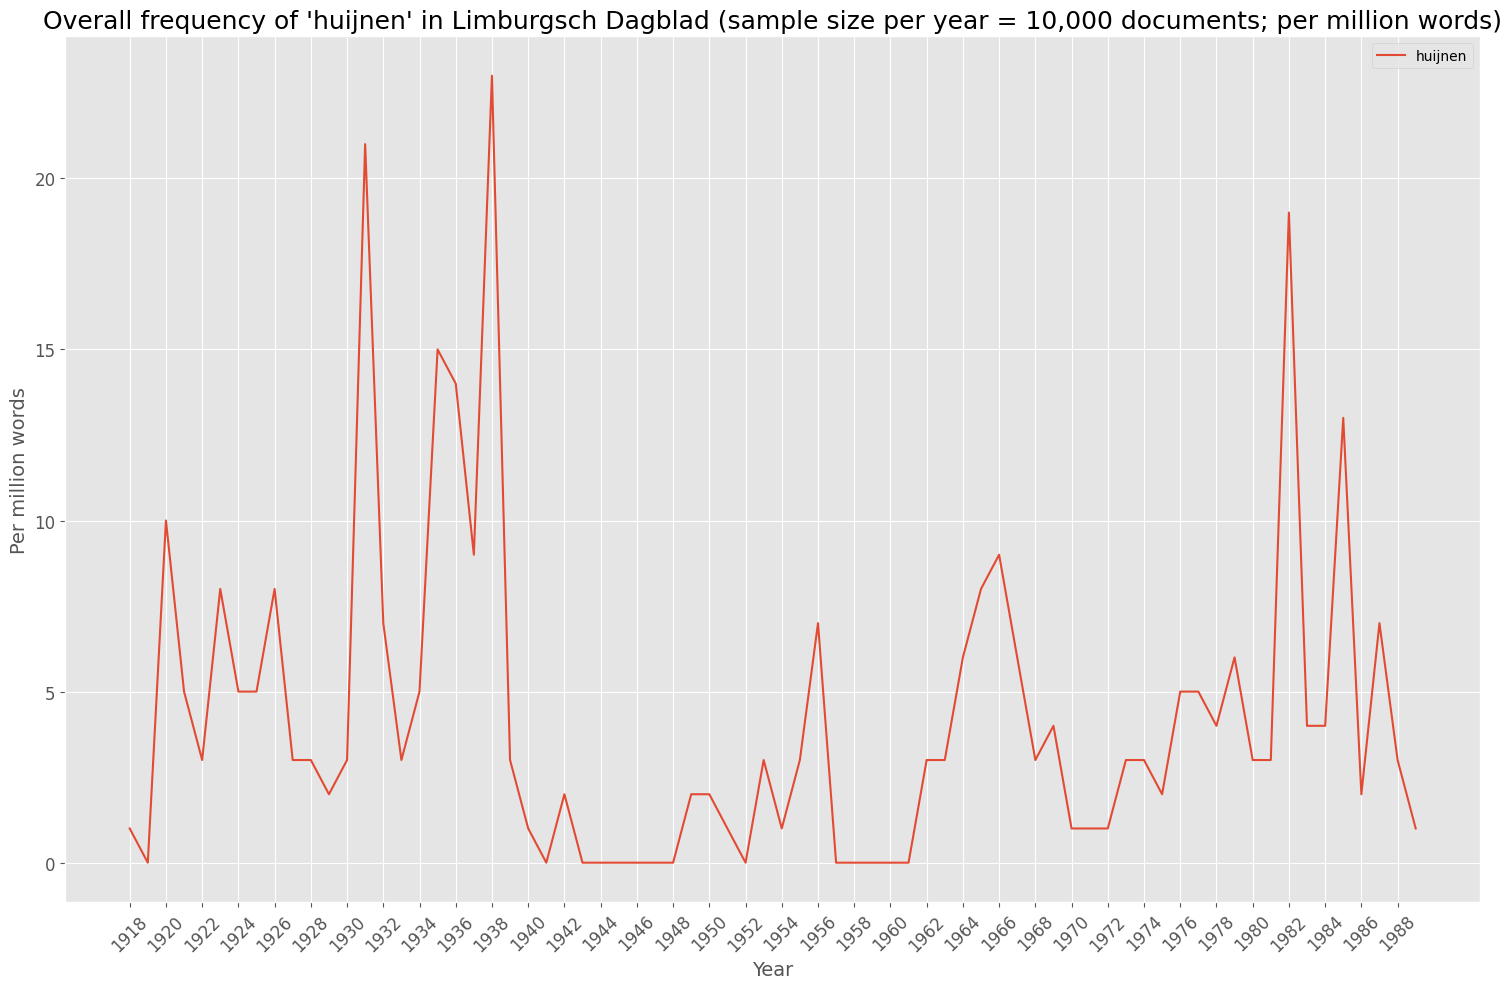

In [24]:
# Create a custom color palette with enough unique colors
custom_palette = sns.color_palette("Dark2")

# Create a new figure and axis
plt.style.use("ggplot")
fig, ax = plt.subplots(figsize=(15, 10))

# Plot the lines with the custom color palette
ax.plot(corpus_huijnen.index, corpus_huijnen['huijnen'], label='huijnen')


# Format the x-axis to show only years
years = corpus_huijnen.index.year
ax.set_xticks(corpus_huijnen.index[years % 2 == 0])
ax.set_xticklabels(corpus_huijnen.index[years % 2 == 0].strftime('%Y'), rotation=45, size=12)
ax.tick_params(axis='y', labelsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Set labels and legend
plt.title("Overall frequency of 'huijnen' in %s (sample size per year = 10,000 documents; per million words)" %(paper), size=18)
plt.xlabel("Year", size=14)
plt.ylabel("Per million words", size=14)
plt.legend()

# Save the plot to desktop
plt.savefig("/Users/huijn001/Desktop/Jaren_geleden_huijnen_%s.png" %(paper_short), dpi=300)

# Show the plot
plt.tight_layout()
plt.show()

### Trends in 'jaar geleden' and 'jaren geleden'

In [25]:
def legend_name(i):
    """Function for turning df columns into legend names"""
    i = i[:-9]
    i_legend = i.replace('_',' ')
    return i_legend

In [26]:
corpus2['jaar_geleden_perwords'] = corpus2['jaar_geleden'] / corpus2['no_words'] * 1000000
corpus2['jaren_geleden_perwords'] = corpus2['jaren_geleden'] / corpus2['no_words'] * 1000000
corpus2['jaar_jaren_geleden_perwords'] = corpus2['jaar_jaren_geleden'] / corpus2['no_words'] * 1000000

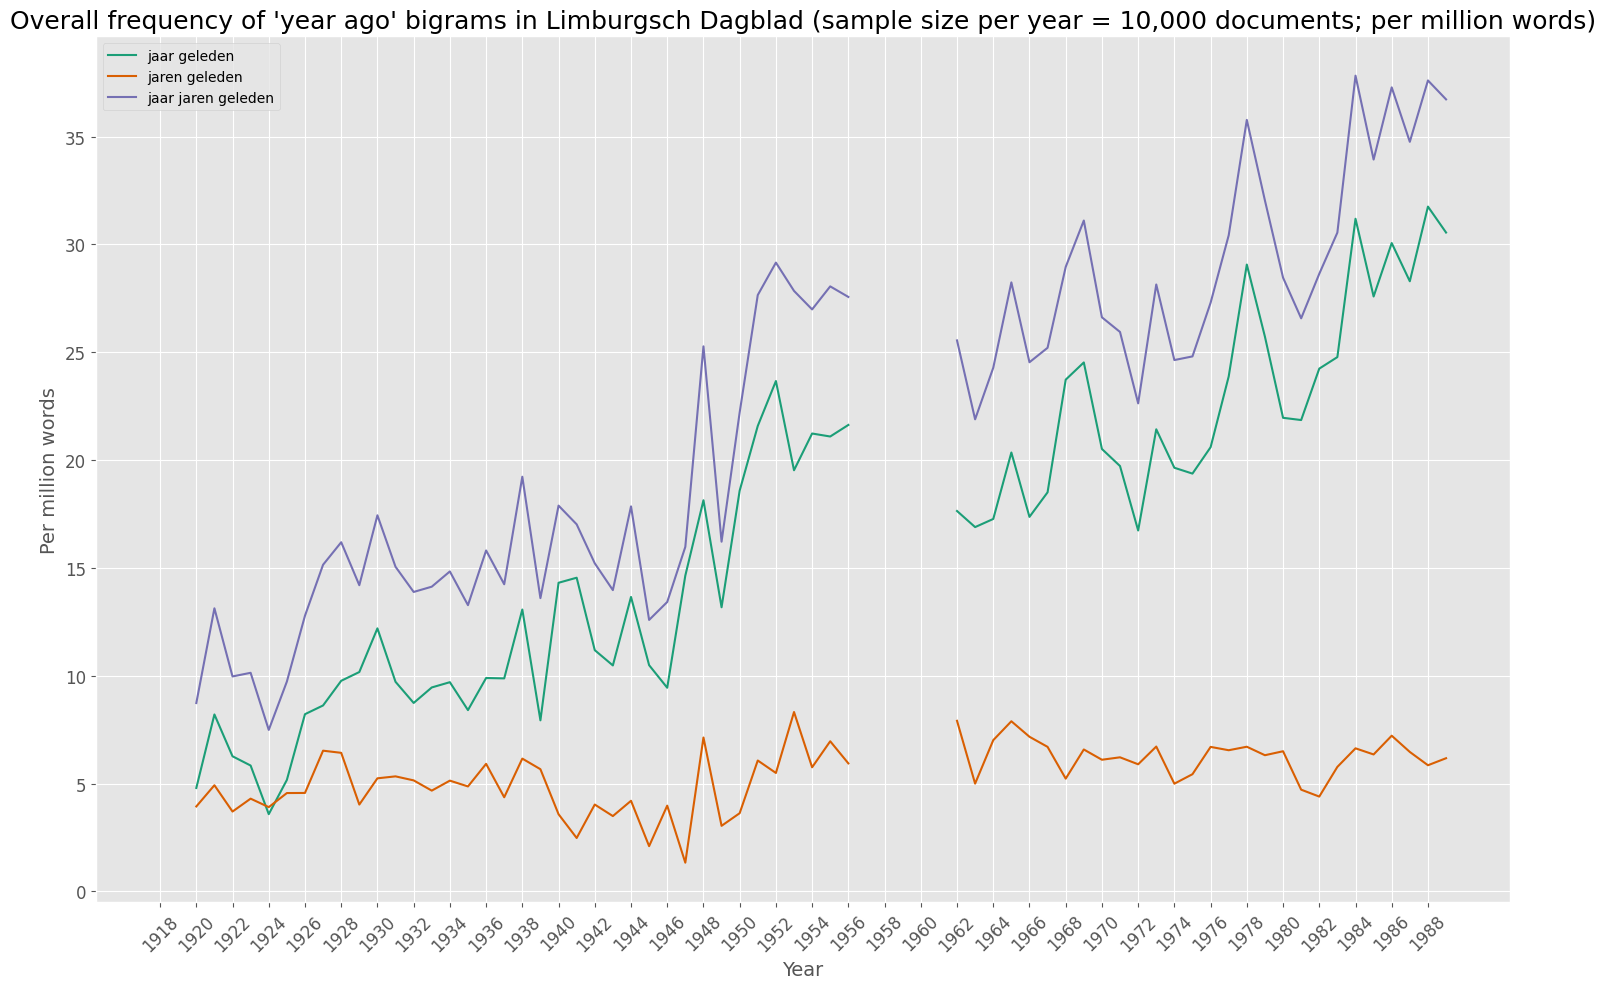

In [27]:
jaren_geleden = corpus2[['jaar_geleden_perwords', 'jaren_geleden_perwords', 'jaar_jaren_geleden_perwords']]

# Create a custom color palette with enough unique colors
custom_palette = sns.color_palette("Dark2")

# Create a new figure and axis
plt.style.use("ggplot")
fig, ax = plt.subplots(figsize=(15, 10))

# Plot the lines with the custom color palette
for i, col in enumerate(jaren_geleden):
    col_name = legend_name(col)
    ax.plot(corpus2.index, corpus2[col], label=col_name, color=custom_palette[i])


# Format the x-axis to show only years
years = corpus2.index.year
ax.set_xticks(corpus2.index[years % 2 == 0])
ax.set_xticklabels(corpus2.index[years % 2 == 0].strftime('%Y'), rotation=45, size=12)
ax.tick_params(axis='y', labelsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Set labels and legend
plt.title("Overall frequency of 'year ago' bigrams in %s (sample size per year = 10,000 documents; per million words)" %(paper), size=18)
plt.xlabel("Year", size=14)
plt.ylabel("Per million words", size=14)
plt.legend()

# Save the plot to desktop
plt.savefig("/Users/huijn001/Desktop/Jaren_geleden_overall_%s.png" %(paper_short), dpi=300)

# Show the plot
plt.tight_layout()
plt.show()

### Method 1: Calculate relative frequencies of each jaar in jaren relative to the total number of words per year * 10n6

In [28]:
for jaar in jaren:
    corpus2[jaar + '_perwords'] = corpus2[jaar] / corpus2['no_words'] * 1000000

In [29]:
perwords_columns = [col for col in corpus2 if str(col).endswith(('_perwords'))]
corpus_perwords = corpus2.filter(perwords_columns, axis=1)

In [30]:
corpus_perwords.to_csv('/Users/huijn001/Desktop/%s_every_years_ago_perwords.csv' %(paper_short), sep='\t')

In [31]:
print(corpus_perwords.tail())

            jaar_geleden_perwords  jaren_geleden_perwords  \
date                                                        
1985-12-31              27.587775                6.350393   
1986-12-31              30.066065                7.219812   
1987-12-31              28.293357                6.467053   
1988-12-31              31.756919                5.849959   
1989-12-31              30.553427                6.175693   

            jaar_jaren_geleden_perwords  twee_perwords  drie_perwords  \
date                                                                    
1985-12-31                    33.938168       4.164192       0.936943   
1986-12-31                    37.285877       5.538486       1.978031   
1987-12-31                    34.760410       3.334574       1.616763   
1988-12-31                    37.606878       5.118714       2.193735   
1989-12-31                    36.729119       4.225474       1.733528   

            vier_perwords  vijf_perwords  zes_perwords  zeve

### Method 2: Calculate normalized frequencies of each jaar in jaren relative to the total frequency of bigram 'jaar geleden'/'jaren geleden'

In [32]:
for jaar in jaren:
    corpus2[jaar + '_nor'] = corpus2[jaar] / corpus2['jaar_jaren_geleden']

Make new dataframe without text column (while keeping corpus2 intact).

In [33]:
nor_columns = [col for col in corpus2 if str(col).endswith(('_nor'))]
corpus_nor = corpus2.filter(nor_columns, axis=1)

In [34]:
corpus_nor.to_csv('/Users/huijn001/Desktop/%s_every_years_ago_normalized.csv' %(paper_short), sep='\t')

In [35]:
print(corpus_nor.head())

            twee_nor  drie_nor  vier_nor  vijf_nor   zes_nor  zeven_nor  \
date                                                                      
1918-12-31  0.111111  0.000000  0.000000  0.111111  0.000000        0.0   
1919-12-31       NaN       NaN       NaN       NaN       NaN        NaN   
1920-12-31  0.176471  0.039216  0.019608  0.019608  0.019608        0.0   
1921-12-31  0.125000  0.000000  0.000000  0.025000  0.050000        0.0   
1922-12-31  0.142857  0.028571  0.028571  0.057143  0.028571        0.0   

            acht_nor  negen_nor  tien_nor  elf_nor  ...  honderdtien_nor  \
date                                                ...                    
1918-12-31  0.000000        0.0  0.111111      0.0  ...              0.0   
1919-12-31       NaN        NaN       NaN      NaN  ...              NaN   
1920-12-31  0.019608        0.0  0.039216      0.0  ...              0.0   
1921-12-31  0.000000        0.0  0.025000      0.0  ...              0.0   
1922-12-31  0.0000

### Making line charts based on 'n years ago'

<b>Line chart per year based on corpus2_rel</b>

In [45]:
jaren2 = ['vier']
#jaren2 = ['twee', 'drie', 'vier', 'vijf', 'zes', 'zeven', 'acht', 'negen', 'tien']
#jaren2 = ['tien', 'twintig', 'dertig', 'veertig', 'vijftig', 'zestig', 'zeventig', 'tachtig', 'negentig', 'honderd']
#jaren2 = ['tien', 'honderd', 'tweehonderd']
jaren_str = '_'.join(jaren2)

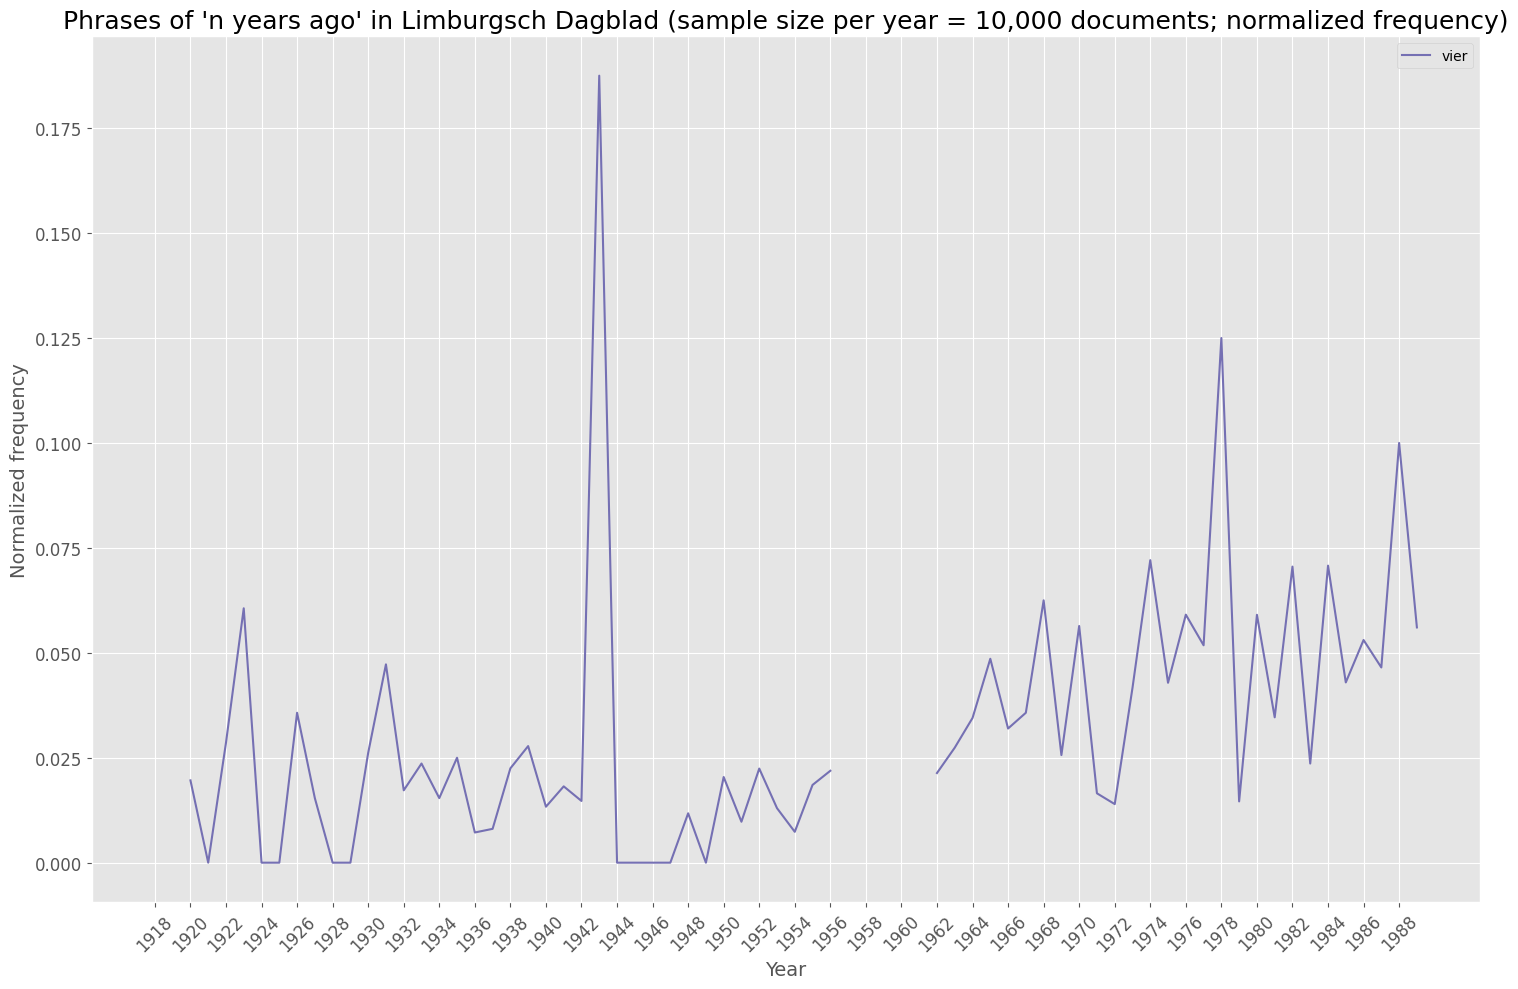

In [39]:
# Create a custom color palette with enough unique colors
custom_palette = sns.color_palette("Dark2", len(corpus_nor.columns))

# Create a new figure and axis
plt.style.use("ggplot")
fig, ax = plt.subplots(figsize=(15, 10))

# Plot the lines with the custom color palette
for i, col in enumerate(corpus_nor.columns):
    if str(col)[:-4] in jaren2:
        col_name = str(col)[:-4]
        ax.plot(corpus_nor.index, corpus_nor[col], label=col_name, color=custom_palette[i])

# Format the x-axis to show only years
years = corpus_nor.index.year
ax.set_xticks(corpus_nor.index[years % 2 == 0])
ax.set_xticklabels(corpus_nor.index[years % 2 == 0].strftime('%Y'), rotation=45, size=12)
ax.tick_params(axis='y', labelsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Set labels and legend
plt.title("Phrases of 'n years ago' in " + paper + " (sample size per year = 10,000 documents; normalized frequency)", size=18)
plt.xlabel("Year", size=14)
plt.ylabel("Normalized frequency", size=14)
plt.legend()

# Save the plot to desktop
plt.savefig("/Users/huijn001/Desktop/%s_%s_normalized.png" %(paper_short, jaren_str), dpi=300)

# Show the plot
plt.tight_layout()
plt.show()


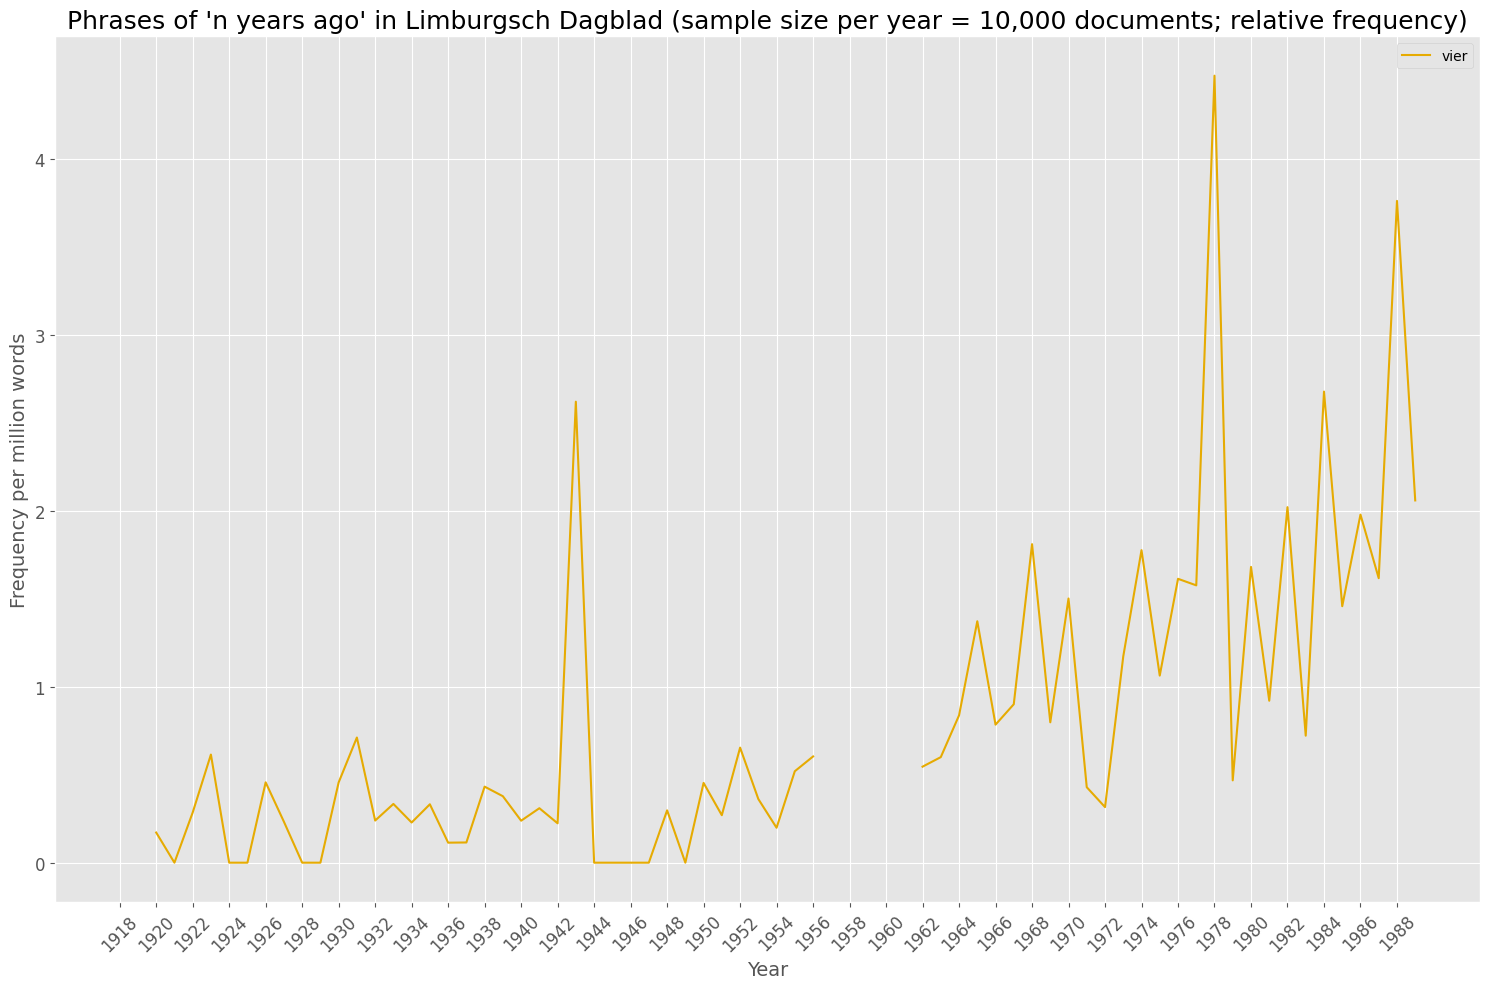

In [46]:
# Create a custom color palette with enough unique colors
custom_palette = sns.color_palette("Dark2", len(corpus_perwords.columns))

# Create a new figure and axis
plt.style.use("ggplot")
fig, ax = plt.subplots(figsize=(15, 10))

# Plot the lines with the custom color palette
for i, col in enumerate(corpus_perwords.columns):
    if str(col)[:-9] in jaren2:
        col_name = str(col)[:-9]
        ax.plot(corpus_perwords.index, corpus_perwords[col], label=col_name, color=custom_palette[i])

# Format the x-axis to show only years
years = corpus_perwords.index.year
ax.set_xticks(corpus_perwords.index[years % 2 == 0])
ax.set_xticklabels(corpus_perwords.index[years % 2 == 0].strftime('%Y'), rotation=45, size=12)
ax.tick_params(axis='y', labelsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Set labels and legend
plt.title("Phrases of \'n years ago\' in " + paper + " (sample size per year = 10,000 documents; relative frequency)", size=18)
plt.xlabel("Year", size=14)
plt.ylabel("Frequency per million words", size =14)
plt.legend()

# save the plot to desktop
plt.savefig("/Users/huijn001/Desktop/%s_%s_years_perwords.png" %(paper_short, jaren_str), dpi=300)

# Show the plot
plt.tight_layout()
plt.show()

## References to last year

In [ ]:
corpus4 = corpus2.copy()

Method 1:

In [ ]:
corpus4['een_jaar_geleden_perwords'] = corpus4['een_jaar_geleden'] / corpus4['no_words'] * 1000000
corpus4['afgelopen_jaar_perwords'] = corpus4['afgelopen_jaar'] / corpus4['no_words'] * 1000000
corpus4['vorig_jaar_perwords'] = corpus4['vorig_jaar'] / corpus4['no_words'] * 1000000
corpus4['verleden_jaar_perwords'] = corpus4['verleden_jaar'] / corpus4['no_words'] * 1000000

In [ ]:
year_perwords_columns = ['een_jaar_geleden_perwords', 'afgelopen_jaar_perwords', 'vorig_jaar_perwords', 'verleden_jaar_perwords']
corpus_year_perwords = corpus4.filter(year_perwords_columns, axis=1)

In [ ]:
corpus_year_perwords.to_csv('/Users/huijn001/Desktop/%s_lastyear_perwords.csv' %(paper_short), sep='\t')

In [ ]:
print(corpus_year_perwords.head())

In [ ]:
# Create a new figure and axis
plt.style.use("ggplot")
fig, ax = plt.subplots(figsize=(15, 10))

# Plot the lines
for col in corpus_year_perwords.columns:
    col_name = str(col)[:-9]
    print(col_name)
    ax.plot(corpus_year_perwords.index, corpus_year_perwords[col], label=col_name)

# Format the x-axis to show only years
years = corpus_year_perwords.index.year
ax.set_xticks(corpus_year_perwords.index[years % 2 == 0])
ax.set_xticklabels(corpus_year_perwords.index[years % 2 == 0].strftime('%Y'), rotation=45, size=12)
ax.tick_params(axis='y', labelsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Set labels and legend
plt.title("Varieties of references to last year in " + paper + " (sample size per year = 10,000 documents; relative frequency)", size=18)
plt.xlabel("Year", size=14)
plt.ylabel("Frequency per million words", size =14)
plt.legend()

# save the plot to desktop
plt.savefig("/Users/huijn001/Desktop/%s_lastyear_perwords.png" %(paper_short), dpi=300)

# Show the plot
plt.tight_layout()
plt.show()

Method 3:

In [ ]:
corpus4['een_jaar_geleden_nor'] = corpus4['een_jaar_geleden'] / corpus4['jaar_jaren_geleden']
corpus4['afgelopen_jaar_nor'] = corpus4['afgelopen_jaar'] / corpus4['jaar_jaren_geleden']
corpus4['vorig_jaar_nor'] = corpus4['vorig_jaar'] / corpus4['jaar_jaren_geleden']
corpus4['verleden_jaar_nor'] = corpus4['verleden_jaar'] / corpus4['jaar_jaren_geleden']

In [ ]:
year_nor_columns = ['een_jaar_geleden_nor', 'afgelopen_jaar_nor', 'vorig_jaar_nor', 'verleden_jaar_nor']
corpus_year_nor = corpus4.filter(year_nor_columns, axis=1)

In [ ]:
corpus_year_perwords.to_csv('/Users/huijn001/Desktop/%s_lastyear_nor.csv' %(paper_short), sep='\t')

In [ ]:
# Create a new figure and axis
plt.style.use("ggplot")
fig, ax = plt.subplots(figsize=(15, 10))

# Plot the lines
for col in corpus_year_nor.columns:
    col_name = str(col)[:-4]
    print(col_name)
    ax.plot(corpus_year_nor.index, corpus_year_nor[col], label=col_name)

# Format the x-axis to show only years
years = corpus_year_nor.index.year
ax.set_xticks(corpus_year_nor.index[years % 2 == 0])
ax.set_xticklabels(corpus_year_nor.index[years % 2 == 0].strftime('%Y'), rotation=45, size=12)
ax.tick_params(axis='y', labelsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Set labels and legend
plt.title("Varieties of references to last year in " + paper + " (sample size per year = 10,000 documents; normalized frequency)", size=18)
plt.xlabel("Year", size=14)
plt.ylabel("Normalized frequency", size =14)
plt.legend()

# save the plot to desktop
plt.savefig("/Users/huijn001/Desktop/%s_lastyear_nor.png" %(paper_short), dpi=300)

# Show the plot
plt.tight_layout()
plt.show()

## Counting frequency of years refered to by 'n years ago'

In [ ]:
corpus3.index = corpus3.index.year

In [ ]:
corpus3.reset_index(inplace=True) # turn 'date' into normal column to calculate target_year ('jaar_' + jaar)

In [ ]:
print(corpus3.head())

In [ ]:
numbers = {'1':'een', '2':'twee', '3':'drie', '4':'vier', '5':'vijf', '6':'zes', '7':'zeven', '8':'acht', '9':'negen', '10':'tien', '11':'elf', '12':'twaalf', '13':'dertien', '14':'veertien', '15':'vijftien', '16':'zestien', '17':'zeventien', '18':'achttien', '19':'negentien', '20':'twintig', '30':'dertig', '40':'veertig', '50':'vijftig', '60':'zestig', '70':'zeventig', '80':'tachtig', '90':'negentig', '100':'honderd', '110':'honderdtien', '120':'honderdtwintig', '130':'honderddertig', '140':'honderdveertig', '150':'honderdvijftig', '160':'honderdzestig', '170':'honderdzeventig', '180':'honderdtachtig', '190':'honderdnegentig', '200':'tweehonderd'}

def word_to_number(getal):
    for number, word in numbers.items():
        if getal == word:
            word_number = number
    return int(word_number)

def jaar_geleden(jaar): # Herhaling van hierboven, omdat dat om de een of andere reden moet. Werkt dit?
    jaar_geleden = jaar + ' jaar geleden'
    return str(jaar_geleden)

def over_jaar(jaar): # Herhaling van hierboven, omdat dat om de een of andere reden moet. Werkt dit?
    over_jaar = 'over ' + jaar + ' jaar'
    return str(over_jaar)

In [ ]:
print(len(jaren))

Deze loop maakt voor elk jaar in jaren een kolom in corpus2 die uitrekent naar welk jaar 'n jaar geleden' verwijst. Vervolgens maakt hij een dictionary die voor elk jaar het jaar-waarnaar-verwezen-wordt als key neemt en de frequentie van de string 'n jaar geleden' als value. Dit telt de loop voor elk jaar in jaren bij elkaar op in final_dict (gaat via Counter, daarom lege Counter(add_dict) gemaakt).

In [ ]:
final_dict = {}
add_dict = {}
add_dict = Counter(add_dict)

for jaar in jaren:
    corpus3['jaar_' + jaar] = [row - word_to_number(jaar) for row in corpus3['date'].astype(int)]
    mydict = {d['jaar_' + jaar]: d[query_column(jaar_geleden(jaar)) + '_raw'] for d in corpus3.to_dict(orient='records')} # https://stackoverflow.com/questions/40924592/python-dictionary-comprehension-with-pandas
    mydict_counter = Counter(mydict) # https://www.kite.com/python/answers/how-to-add-values-from-two-dictionaries-in-python
    add_dict = add_dict + mydict_counter
    
final_dict = dict(add_dict)
    

In [ ]:
print(corpus3.head())

In [ ]:
print(final_dict)

In [ ]:
df_years_ago = pd.DataFrame.from_dict(final_dict, orient='index')
df_years_ago = df_years_ago.sort_index(axis = 0)
print(df_years_ago.head())

In [ ]:
fig, ax = plt.subplots(figsize = [15,8])
cmap = plt.get_cmap('Dark2')

ax.bar(df_years_ago.index, df_years_ago[0], color=cmap(0))
plt.xticks(np.arange(min(df_years_ago.index), max(df_years_ago.index)+1, 5.0))
plt.xticks(rotation=45)
ax.set_xlabel('Time')
ax.set_ylabel('Frequency per Million words')
ax.set_title('Years refered to via \'n years ago\' in ' + paper +  ' (sample size per year = 10,000 docs)')
plt.show()

In [ ]:
fig.savefig("/Users/huijn001/Desktop/%s_years_ago_ref.png" %(paper_short), dpi=300)

### Slicing on centuries

In [ ]:
seventeen = df_years_ago.loc[1720:1800]
eighteen = df_years_ago.loc[1800:1900]
nineteen = df_years_ago.loc[1900:2000]
centuries = [seventeen, eighteen, nineteen]

In [ ]:
fig, axs = plt.subplots(3,1, figsize = [15,20], sharey=False)
num_colors2 = len(centuries)
cmap = plt.get_cmap('Dark2') # See https://matplotlib.org/stable/tutorials/colors/colormaps.html

for no, i in enumerate(centuries):
    ax = axs[no]
    ax.bar(i.index, i[0], color=cmap(no))
    ax.set_xticks(np.arange(min(i.index), max(i.index)+1, 5.0))
    ax.set_xlabel('Time')
    ax.set_ylabel('Frequency per Million words')
    ax.set_title('Years referred to via \'n years ago\' in ' + paper + ' (sample size per year = 10,000 docs)')
plt.show()

In [ ]:
fig.savefig("/Users/huijn001/Desktop/" + paper_short + "_years_ago_ref1.png", dpi=300)

In [ ]:
df_years_ago.to_csv("/Users/huijn001/Desktop/years_referenced_%s.csv" %(paper_short), sep='\t')

## Create list of n-grams of variations of "n years ago"

Creating a matrix of years (rows) and variations of "n years ago" (columns)

In [ ]:
corpus5 = corpus.resample('Y').sum()

In [ ]:
corpus3 = corpus.groupby((corpus.index.year//10)*10).sum()
corpus3["no_words"] = corpus3["text_clean"].str.len()

In [ ]:
print(corpus3.shape)

In [ ]:
print(corpus3.head(10))

In [ ]:
ago_df_final = pd.DataFrame()

for index, row in log_progress(corpus3.iterrows()):
    text_list = corpus3.loc[index, 'text_clean'].split()
    columns = ['first', 'second', 'third']
    ngrams_df = pd.DataFrame(ngrams(text_list, 3), columns = columns).astype(str)
    ngrams_df['trigrams'] = ngrams_df['first'].str.cat([ngrams_df['second'], ngrams_df['third']], sep=' ')
    ngrams_df.drop(['first', 'second', 'third'], axis=1, inplace=True)
    ngrams_df['no_trigrams'] = len(ngrams_df['trigrams'])
    ngrams_df['ago'] = ngrams_df['trigrams'][ngrams_df['trigrams'].str.endswith(r"jaar geleden|jaren geleden")]
    ago_df = ngrams_df['ago'].value_counts().rename_axis('jaar').to_frame(index).transpose()
    ago_df['no_trigrams'] = ngrams_df['no_trigrams']
    ago_df_final = pd.concat([ago_df_final, ago_df], axis=0, ignore_index=False) 

In [ ]:
ago_df_final['no_words'] = corpus3['no_words']

In [ ]:
print(ago_df_final.head())

In [ ]:
for column in ago_df_final:
    ago_df_final[column] = (ago_df_final[column] / ago_df_final['no_trigrams']) * 1000000

In [ ]:
print(ago_df_final.head())

Transposing the df above into a matrix of variations of "n years ago" (rows) and years (columns)

In [ ]:
ago_df_final_trp3 = ago_df_final.transpose()
print(ago_df_final_trp3.head())

In [ ]:
ago_df_final_trp3.to_csv('/Users/huijn001/Desktop/Telegraaf10000_geleden_ngrams_permilltrigrams.csv')

In [ ]:
ago_df_final_trp3 = pd.read_csv('/Users/huijn001/Desktop/Telegraaf10000_geleden_ngrams_permill.csv', index_col=0)

In [ ]:
print(ago_df_final_trp3.head())

Sum all rows (= variations of "years ago") per decade from ago_df_final_trp3 and put in dictionary 'total_dict'

In [ ]:
print(int(ago_df_final_trp3['1890'].sum()) - 1000000)

In [ ]:
total_dict = {}

for column in ago_df_final_trp3:
    total = ago_df_final_trp3[column].sum() - 1000000
    total_dict[column] = int(total)

In [ ]:
print(total_dict)

In [ ]:
keys = total_dict.keys()

values = total_dict.values()


plt.bar(keys, values)
plt.show()